# Burst Weights

*This notebook generates plots for burst weights section of the paper:*

<br>
<div class="alert alert-success">
<b>FRETBursts: Open Source Burst Analysis Toolkit for Confocal Single-Molecule FRET</b><br>
Ingargiola et al. (2016). biorXiv doi:<a href="http://dx.doi.org/10.1101/039198" target="_blank">10.1101/039198</a>
</div>

> The main notebook is: [FRETBursts Paper Main Notebook](FRETBursts Paper Main Notebook.ipynb)

# Loading software

Load software and define default figure style.

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.5.5).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1101/039198 

--------------------------------------------------------------


In [2]:
from matplotlib.patches import Polygon
from scipy.stats import binom, expon, gamma, poisson

In [3]:
sns = init_notebook(seaborn_style='ticks')

In [4]:
figure_size = (5, 4)
default_figure = lambda: plt.subplots(figsize=figure_size)
save_figures = True

def savefig(filename, **kwargs):
    if not save_figures:
        return
    import os
    name, extension = os.path.splitext(os.path.basename(filename))
    dir_ = '../figures/%s/' % name
    kwargs_ = dict(dpi=150, bbox_inches='tight', 
                   frameon=True, facecolor='white', transparent=False)
    kwargs_.update(kwargs)
    plt.savefig(dir_ + name + extension, **kwargs_)

# 1. Estimators Variance

Following the discussion in section SI-8.6, here we compare empirically 
the performances for weighted and unweighted estimators ($\hat{E}_{uw}$ and $\hat{E}_{w}$)
of a static FRET population PR $E_p$:

$$\hat{E}_{uw} = \frac{1}{N} \sum_i E_i$$

$$\hat{E}_w = \frac{1}{N} \sum_i w_i E_i
= \frac{1}{N} \frac{\sum_i n_{ai}}{\sum_i n_{ti}} \quad\textrm{with}\quad
w_i = \frac{n_{ti}}{\sum_i n_{ti}}$$

For this purpose, we generated a static FRET population of N=200 bursts 
by extracting burst-sizes from an exponential distribution ($\lambda = 50$)
and acceptor counts from a binomial distribution ($E_p = 0.2$). 

By repeatedly (`ntrials = 2000`) fitting the population parameter $E_p$ 
we can build the distribution of the two estimators and verify that,
as predicted by theory, the size-weighted estimator ($\hat{E}_w$ )has lower
variance than the unweighted one ($\hat{E}_{uw}$).

We start by definig the function to generate bursts:

In [5]:
def gen_burst_counts_exp(E_p, num_bursts, mean):
    min_burst_size = 3
    nt = (min_burst_size + expon.rvs(scale=mean, size=num_bursts)).astype(int)
    na = binom.rvs(nt, E_p)
    nd = nt - na
    return nd, na

In [6]:
E_p = 0.2
N = 100
ntrials = 5000
mean_burst_size = 10

np.random.seed(54321)
nd, na = gen_burst_counts_exp(E_p, num_bursts=N*ntrials, mean=mean_burst_size)
nd = nd.reshape(ntrials, N)
na = na.reshape(ntrials, N)
nt = na + nd
EE = na / nt

In [7]:
EE.shape

(5000, 100)

Empirical mean burst size:  12.511758


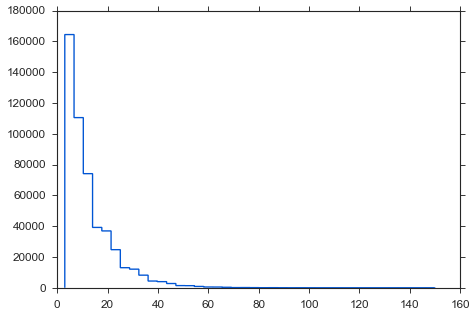

In [8]:
print('Empirical mean burst size: ', (nd + na).ravel().mean())
plt.hist((nd + na).ravel(), bins=40, histtype='step', lw=1.5, );

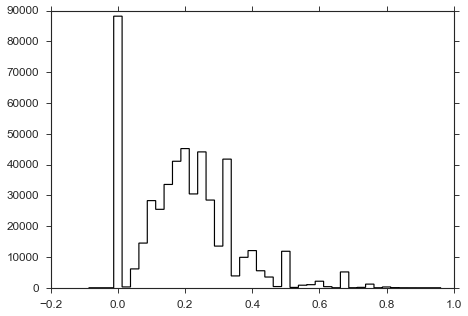

In [9]:
bins = np.arange(-0.075, 1, 0.025) - 0.025/2
plt.hist(EE.ravel(), bins, histtype='step', color='k', lw=1.3);

### Unweighted Estimator

In [10]:
Eh = np.nanmean(EE, axis=1)
Eh_mean, Eh_std = np.nanmean(Eh), np.nanstd(Eh)*100
print('Unweighted E estimator')
print('Mean = %.5f   Std.Dev. = %.4f %%' % (Eh_mean, Eh_std))

Unweighted E estimator
Mean = 0.19991   Std.Dev. = 1.4644 %


### Weighted Estimator

In [11]:
Ehw = np.nansum(EE * nt, axis=1)/ np.nansum(nt, axis=1)
Ehw_mean, Ehw_std = np.nanmean(Ehw), np.nanstd(Ehw)*100
print('Weighted E estimator')
print('Mean = %.5f   Std.Dev. = %.4f %%' % (Ehw_mean, Ehw_std))

Weighted E estimator
Mean = 0.20002   Std.Dev. = 1.1383 %


In [12]:
delta = 100 * (Eh_std - Ehw_std) / Ehw_std
print('Percentage variance increase for the unweighted estimator: %.2f %%' % delta)

Percentage variance increase for the unweighted estimator: 28.65 %


### Estimator distribution plots

In [13]:
sns.set_style('ticks')

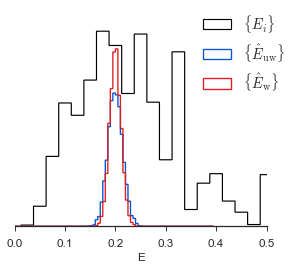

In [14]:
fig, ax = default_figure()
bins = np.arange(0, 1, 0.025) + 0.025*0.5
kws = dict(bins=bins, histtype='step', lw=1.3, normed=True)
_, _, (p0,) = ax.hist(EE.ravel(), color='k', **kws);
ax.set_xlabel('E')

ax2 = plt.twinx()
ax2.grid(False)
ebins = np.arange(0, 0.4, 0.005)
kws.update(bins=ebins, lw=1.5)
_, _, (p1,) = ax2.hist(Eh[np.isfinite(Eh)], **kws);
_, _, (p2,) = ax2.hist(Ehw[np.isfinite(Ehw)], **kws);
ax.set_xlim(0, 0.5);
fig.legend((p0, p1, p2), 
           (r'$\{E_i\}$', r'$\{\hat{E}_{\rm uw}\}$', r'$\{\hat{E}_{\rm w}\}$'),
           fontsize=16, loc='upper right');
ax.yaxis.set_visible(False)
ax2.yaxis.set_visible(False)
sns.despine(fig, left=True, offset=0);

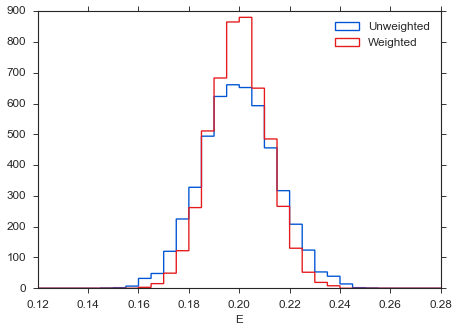

In [15]:
ebins = np.arange(0, 0.4, 0.005)
plt.hist(Eh[np.isfinite(Eh)], ebins, histtype='step', lw=1.5, label='Unweighted');
plt.hist(Ehw[np.isfinite(Ehw)], ebins, histtype='step', lw=1.5, label='Weighted');
plt.xlim(0.2 - 0.08, 0.2 + 0.08);
plt.legend();
plt.xlabel('E');

## Gamma-distributed burst sizes

Let's see how to call a scipy's gamma distribution:

In [16]:
x = np.arange(0,300, 0.1)
mean_ = 50
a = 2
y = gamma.pdf(x, a=a, scale=mean_/a)
y2 = gamma.pdf(x, a=1, scale=mean_)  # this is an exponential

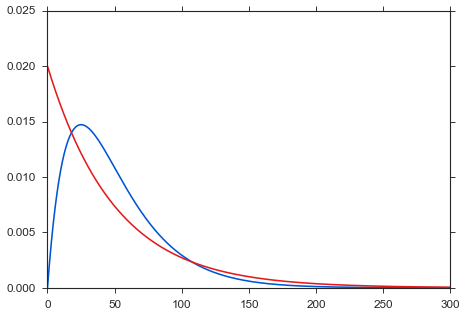

In [17]:
plot(x, y)
plot(x, y2);

Let's perform the same simulation but with a gamma-distributed burst sizes:

In [18]:
def gen_burst_counts_gamma(E_p, num_bursts, mean, a=2):
    nt = gamma.rvs(scale=mean/a, a=a, size=num_bursts).astype(int)
    na = binom.rvs(nt, E_p)
    nd = nt - na
    return nd, na

In [19]:
E_p = 0.2
N = 100
ntrials = 5000
mean_burst_size = 10

np.random.seed(54321)
nd, na = gen_burst_counts_gamma(E_p, num_bursts=N*ntrials, mean=mean_burst_size)
nd = nd.reshape(ntrials, N)
na = na.reshape(ntrials, N)
nt = na + nd
EE = na / nt

### Unweighted Estimator

In [20]:
Eh = np.nanmean(EE, axis=1)
Eh.shape, np.nanmean(Eh), np.nanstd(Eh)*100
print('Unweighted E estimator (Gamma)')
print('Mean = %.5f   Std.Dev. = %.4f %%' % (np.nanmean(Eh), np.nanstd(Eh)*100))

Unweighted E estimator (Gamma)
Mean = 0.20031   Std.Dev. = 1.7917 %


### Weighted Estimator

In [21]:
Ehw = np.nansum(EE * nt, axis=1)/ np.nansum(nt, axis=1)
print('Weighted E estimator (Gamma)')
print('Mean = %.5f   Std.Dev. = %.4f %%' % (np.nanmean(Ehw), np.nanstd(Ehw)*100))

Weighted E estimator (Gamma)
Mean = 0.20014   Std.Dev. = 1.2984 %


### Estimator distribution plots

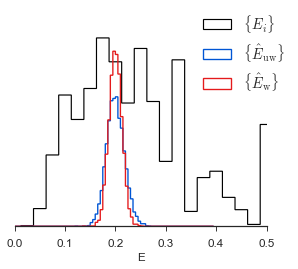

In [22]:
fig, ax = default_figure()
bins = np.arange(0, 1, 0.025) + 0.025*0.5
kws = dict(bins=bins, histtype='step', lw=1.3, normed=True)
_, _, (p0,) = ax.hist(EE.ravel(), color='k', **kws);
ax.set_xlabel('E')

ax2 = plt.twinx()
ax2.grid(False)
ebins = np.arange(0, 0.4, 0.005)
kws.update(bins=ebins, lw=1.5)
_, _, (p1,) = ax2.hist(Eh[np.isfinite(Eh)], **kws);
_, _, (p2,) = ax2.hist(Ehw[np.isfinite(Ehw)], **kws);
ax.set_xlim(0, 0.5);
fig.legend((p0, p1, p2), 
           (r'$\{E_i\}$', r'$\{\hat{E}_{\rm uw}\}$', r'$\{\hat{E}_{\rm w}\}$'),
           fontsize=16, loc='upper right');
ax.yaxis.set_visible(False)
ax2.yaxis.set_visible(False)
sns.despine(fig, left=True, offset=0);

# 2. FRET Histograms

## Getting the data

In [23]:
#url = 'http://files.figshare.com/4917046/smFRET_44f3da_P_20_s0_20_s20_D_6.0e11_6.0e11_E_75_30_EmTot_200k_200k_BgD1500_BgA800_t_max_600s.hdf5'
#download_file(url, save_dir='./data')

In [24]:
url = 'http://files.figshare.com/4917049/smFRET_44f3da_P_20_s0_20_s20_D_6.0e11_6.0e11_E_75_30_EmTot_160k_160k_BgD1500_BgA800_t_max_600s.hdf5'
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/4917049/smFRET_44f3da_P_20_s0_20_s20_D_6.0e11_6.0e11_E_75_30_EmTot_160k_160k_BgD1500_BgA800_t_max_600s.hdf5
File: smFRET_44f3da_P_20_s0_20_s20_D_6.0e11_6.0e11_E_75_30_EmTot_160k_160k_BgD1500_BgA800_t_max_600s.hdf5
 
File already on disk: /Users/anto/src/fretbursts_paper/notebooks/data/smFRET_44f3da_P_20_s0_20_s20_D_6.0e11_6.0e11_E_75_30_EmTot_160k_160k_BgD1500_BgA800_t_max_600s.hdf5 
Delete it to re-download.


In [25]:
filename = './data/' + url.split('/')[-1]
filename

'./data/smFRET_44f3da_P_20_s0_20_s20_D_6.0e11_6.0e11_E_75_30_EmTot_160k_160k_BgD1500_BgA800_t_max_600s.hdf5'

In [26]:
url2 = 'http://files.figshare.com/4916914/008_dsDNA_22d_500pM_green100u_red40u.hdf5'
download_file(url2, save_dir='./data')

URL:  http://files.figshare.com/4916914/008_dsDNA_22d_500pM_green100u_red40u.hdf5
File: 008_dsDNA_22d_500pM_green100u_red40u.hdf5
 
File already on disk: /Users/anto/src/fretbursts_paper/notebooks/data/008_dsDNA_22d_500pM_green100u_red40u.hdf5 
Delete it to re-download.


In [27]:
filename2 = './data/' + url2.split('/')[-1]
filename2

'./data/008_dsDNA_22d_500pM_green100u_red40u.hdf5'

## Loading the Data

In [28]:
d = loader.photon_hdf5(filename)

In [29]:
d2 = loader.photon_hdf5(filename2)
loader.alex_apply_period(d2)

#donor: 699249  #acceptor: 1428691 



## Background Estimation

Background estimation automatic threshold and a background period of 20s:

In [30]:
d.calc_bg(bg.exp_fit, time_s=40, tail_min_us='auto', F_bg=1.7)
d2.calc_bg(bg.exp_fit, time_s=40, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... [DONE]
 - Calculating BG rates ... [DONE]


> For more info see [Background estimation](http://nbviewer.jupyter.org/github/tritemio/FRETBursts_notebooks/blob/master/notebooks/FRETBursts%20-%20us-ALEX%20smFRET%20burst%20analysis.ipynb#Background-estimation) in the us-ALEX tutorial.

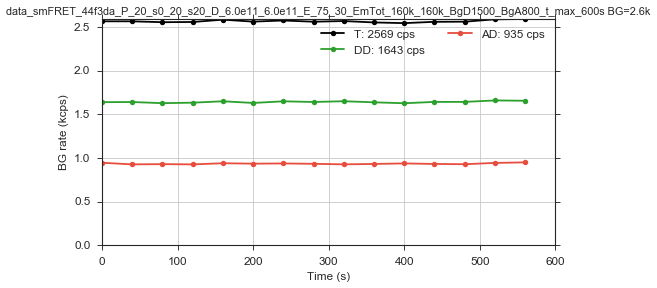

In [31]:
dplot(d, timetrace_bg);

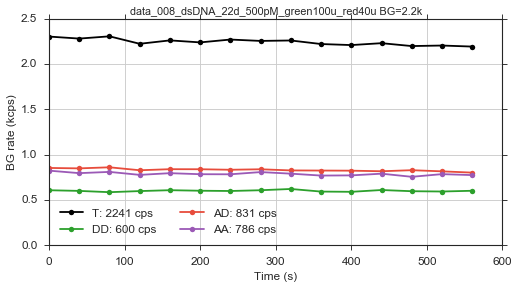

In [32]:
dplot(d2, timetrace_bg);

In [33]:
d.burst_search(F=4)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   [DONE Counting D/A]


In [34]:
ds = d.select_bursts(select_bursts.size, th1=10)

In [35]:
sns = init_notebook(fs=13, savefig_dpi=75, seaborn_style='ticks')

 - Overwriting the old E_fitter object with the new weights.


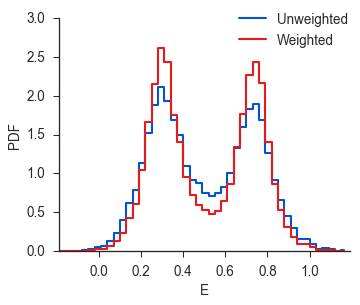

In [36]:
fig, ax = default_figure()
kws = dict(hist_style='step', hist_plot_style=dict(alpha=1, drawstyle='steps-mid', marker=None))
dplot(ds, hist_fret, **kws, ax=ax)
dplot(ds, hist_fret, weights='size', ax=ax, **kws)
ax.set_title('');
sns.despine()
ax.grid(False)
ax.legend(['Unweighted', 'Weighted'],
          bbox_to_anchor=(0.6, 1.05), loc=2, borderaxespad=0.)

savefig('weight_fret_hist_sim_mixture.png')

In [37]:
d2.burst_search(F=4)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]


In [38]:
dd2 = bext.burst_search_and_gate(d2, F=4)

Deep copy executed.
Deep copy executed.
Deep copy executed.
 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Performing burst search (verbose=False) ... - Recomputing background limits for AexAem ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.
   [DONE Counting D/A]


In [39]:
d2t = dd2.select_bursts(select_bursts.time, time_s2=600)
ds2 = d2t.select_bursts(select_bursts.size, th1=10)
ds2a = d2t.select_bursts(select_bursts.naa, th1=10)
#ds2h = d2t.select_bursts(select_bursts.size, th1=20)
#ds2ha = d2t.select_bursts(select_bursts.naa, th1=20)

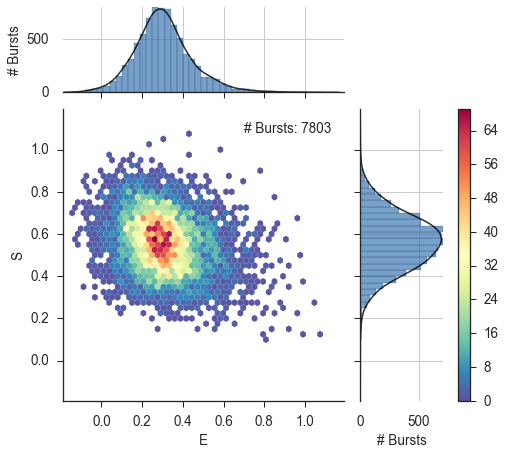

In [40]:
alex_jointplot(ds2)

 - Overwriting the old E_fitter object with the new weights.


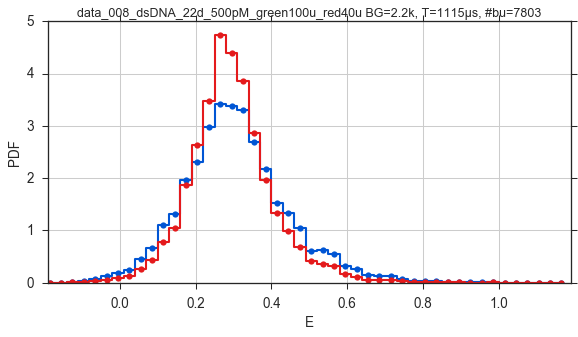

In [41]:
# 600s, DCBS, F=4, size th1 = 10
kws = dict(hist_style='step', hist_plot_style=dict(alpha=1, drawstyle='steps-mid'))
ax = dplot(ds2, hist_fret, **kws)
dplot(ds2, hist_fret, weights='size', ax=ax, **kws)

 - Overwriting the old E_fitter object with the new weights.
 - Overwriting the old E_fitter object with the new weights.


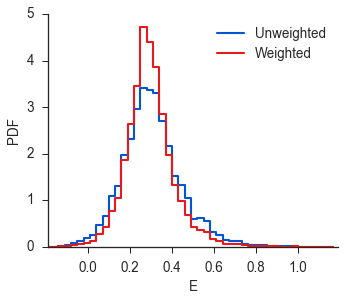

In [42]:
# 600s, DCBS, F=4, size th1 = 10
fig, ax = default_figure()
kws = dict(ax=ax, hist_style='step', 
           hist_plot_style=dict(alpha=1, linestyle='-', marker=None, drawstyle='steps-mid'))
dplot(ds2, hist_fret, **kws)
dplot(ds2, hist_fret, weights='size', **kws)
sns.despine()
ax.set_title('')
ax.grid(False)
ax.legend(['Unweighted', 'Weighted']);

savefig('weight_fret_hist_measurement.png')

# Note on "alternative" Weights

It may be tempting to use weights that put even more "weight" on
large-size bursts (such as size^2, size^3, etc.).
While the use of weight proportional to burst size is grounded
on statistical basis, other these "alternative" weights are arbitrary.

While these weights may results in  FRET histograms with sharper peaks, 
they also place a disproportionate amount of "weight" in the highest bursts.
In this case, a few high bursts may dominate the FRET histogram,
resulting in more statistical noise (especially in the bins close to the peak)
and a decrease in accuracy in the peak position. 

Empirically, FRET histograms built with these "faster increasing" weights 
resemble unweighed histograms obtained with high burst-size thresholds.